# Neural Machine Translation

- Input is a sentence (sequence) in English 
- Output is the corresponding sequence in German
- Encoder Decoder model

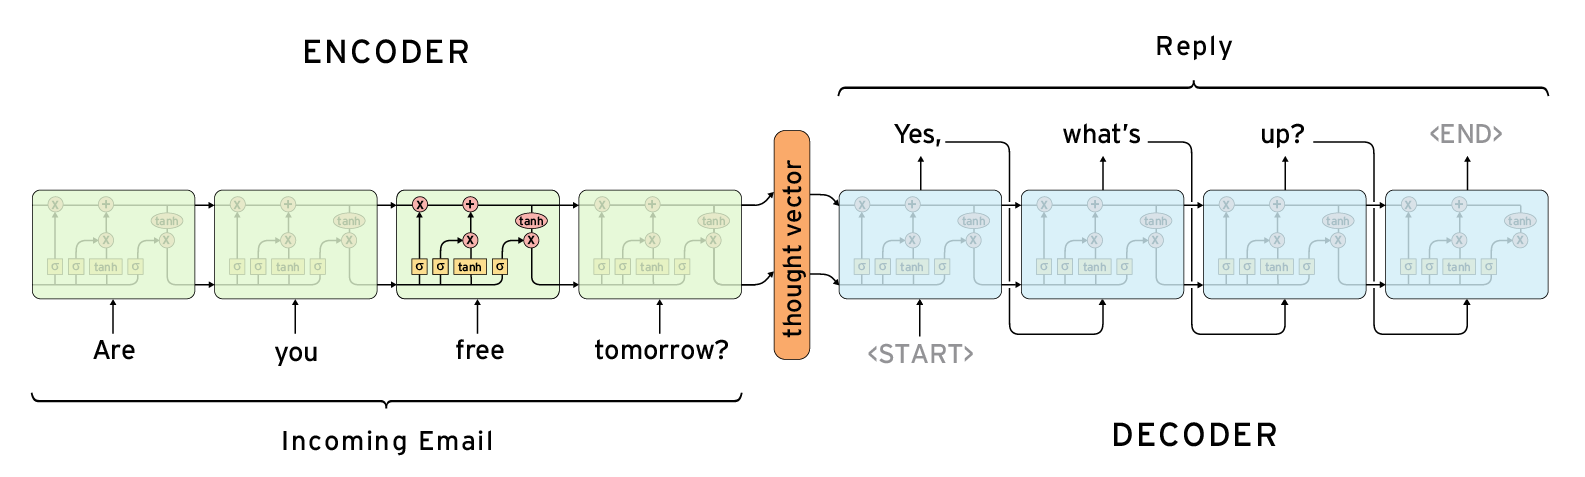

# TODO

1. Implement attention
2. Bidirectional LSTM
3. Comment CODE!!
4. Padding function (if validation sentence > max_length)

## Import needed libraries

In [1]:
import tensorflow as tf
import numpy as np

import text_processing
import dictionary
import utils
import neural_network

# Update python files
%load_ext autoreload
%autoreload 2

/home/francesco/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Data processing

### Read dataset

In [2]:
# Read file containing english and german translations
data = text_processing.load_doc("./ENG_to_GER.txt")

# Split data into english and german
english_sentences, german_sentences = text_processing.prepare_data(data)

# Check and print number of sentences from one language to the other
assert(len(english_sentences) == len(german_sentences))
print(english_sentences.shape)

# Example of sentence with translation
print(english_sentences[55])
print(german_sentences[55])

(50000,)
['be', 'nice']
['seien', 'sie', 'nett']


### Split dataset (training + validation)

In [3]:
# Split percentage of training and validation
split_percentage = 0.75

# Count how many samples into training dataset
total_dataset = len(english_sentences)
train_dataset = int(total_dataset * split_percentage)

# Set random seed to have always same training and validation split
np.random.seed(42)
train_indices = np.random.choice(total_dataset, train_dataset, replace=False)

# Get training data for the two languages
training_english = english_sentences[train_indices]
training_german = german_sentences[train_indices]

# Get validation data
validation_english = np.delete(english_sentences, train_indices)
validation_german = np.delete(german_sentences, train_indices)

print("Training samples: " + str(training_english.shape[0]))
print("Validation samples: " + str(validation_english.shape[0]))

# Reset seed for randomness
np.random.seed()

Training samples: 37500
Validation samples: 12500


### Create dictionaries for the two languages

In [4]:
# Calculate longest sentence in the two languages
english_max_length = utils.max_length_sentence(training_english)
german_max_length = utils.max_length_sentence(training_german) + 1  # Plus one because I add <START> at the beginning

print("Longest sentence in English has " + str(english_max_length) + " tokens.")
print("Longest sentence in German has " + str(german_max_length) + " tokens.")
print()

# Create dictionaries
english_dictionary = dictionary.LanguageDictionary(training_english, english_max_length)
german_dictionary = dictionary.LanguageDictionary(training_german, german_max_length)

# Calculate size of the dictionaries
english_dictionary_size = len(english_dictionary.index_to_word)
german_dictionary_size = len(german_dictionary.index_to_word)

print("English dictionary size: " + str(english_dictionary_size))
print("German dictionary size: " + str(german_dictionary_size))

# Save dictionaries
utils.save_dump(english_dictionary, "eng_dict.pickle")
utils.save_dump(german_dictionary, "ger_dict.pickle")

Longest sentence in English has 10 tokens.
Longest sentence in German has 13 tokens.

English dictionary size: 6110
German dictionary size: 10259


### Prepare sequences for the Neural Network

In [5]:
# Prepare sequences of training data
train_source_input, train_target_input, train_target_output = utils.prepare_sequences(
                                                                       training_english, 
                                                                       training_german, 
                                                                       english_dictionary, 
                                                                       german_dictionary)

# Prepare sequences of validation data
val_source_input, val_target_input, val_target_output = utils.prepare_sequences(
                                                                       validation_english, 
                                                                       validation_german, 
                                                                       english_dictionary, 
                                                                       german_dictionary)

# Check if same number of samples
assert(len(train_source_input) == len(train_target_input) == len(train_target_output))
assert(len(val_source_input) == len(val_target_input) == len(val_target_output))

# Print statistics
print("Training samples : " + str(len(train_source_input)))
print("Validation samples : " + str(len(val_source_input)))

# Print shapes data
print(train_source_input.shape)
print(train_target_input.shape)
print(train_target_output.shape)

Training samples : 203403
Validation samples : 67836
(203403, 10)
(203403, 13)
(203403,)


### Print sample input data in English, German and next word to be predicted in German

In [6]:
sample_sentence_index = 49
print(train_source_input[sample_sentence_index])
print(train_target_input[sample_sentence_index])

print("SOURCE => " + english_dictionary.indices_to_text(train_source_input[sample_sentence_index]))
print("TARGET => " + german_dictionary.indices_to_text(train_target_input[sample_sentence_index]))
print("PREDICTED => " + german_dictionary.indices_to_text([train_target_output[sample_sentence_index]]))

[19 34 22 35 36 37 38  0  0  0]
[ 1 20 36 37 38  0  0  0  0  0  0  0  0]
SOURCE => i have to be up at six <PAD> <PAD> <PAD>
TARGET => <START> ich muss um sechs <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
PREDICTED => auf


## Neural Network

### Parameters

In [7]:
epochs = 200
batch_size = 64
embedding_size = 300
lstm_neurons = 256
lr = 4e-4

### Create model encoder-decoder with LSTM

In [8]:
tf.reset_default_graph()

# Placeholders
input_sequence = tf.placeholder(tf.int32, (None, english_dictionary.max_length_sentence), 'inputs')
output_sequence = tf.placeholder(tf.int32, (None, german_dictionary.max_length_sentence), 'output')
target_labels = tf.placeholder(tf.int32, (None), 'targets')

# Create graph for the network
logits = neural_network.create_network(input_sequence, 
                                       output_sequence, 
                                       english_dictionary_size, 
                                       german_dictionary_size, 
                                       embedding_size,
                                       lstm_neurons,
                                       verbose=1)

Input sequence: [None, 10]
Encoder embedding: [None, 10, 300]
Encoder last_state: [None, 256]
Decoder output: [None, 3328]
Logits: [None, 10259]


### Set the loss function, optimizer and other useful tensors

In [ ]:
# Cross entropy loss after softmax of logits
ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=target_labels)
loss = tf.reduce_mean(ce)

# Using Adam (Adaptive learning rate + momentum) for the update of the weights of the network
optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

# Useful tensors
scores = tf.nn.softmax(logits)
predictions = tf.to_int32(tf.argmax(scores, axis=1))
correct_mask = tf.to_float(tf.equal(predictions, target_labels))
accuracy = tf.reduce_mean(tf.cast(correct_mask, tf.float32))

### Training of the network

In [ ]:
# Training data variables
num_iterations_training = max(len(train_source_input) // batch_size, 1)
print("Training iterations per epoch: " + str(num_iterations_training))

# Validation data variables
max_val_acc = 0
val_batch_size = 64
num_iterations_validation = max(len(val_source_input) // val_batch_size, 1)

# Initializer for variables in the graph
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# Perform each epoch, shuffle training dataset
indices = list(range(len(train_source_input)))

with tf.Session() as sess:
    
    # Initialize variables in the graph
    sess.run(init)
    
    # Iterate over epochs
    for i in range(epochs):
        
        # Shuffle indices with a random seed
        np.random.seed(42)
        np.random.shuffle(indices)
        
        # Shuffle data to not feed the network with always same sequence of data
        train_source_input = train_source_input[indices]
        train_target_input = train_target_input[indices]
        train_target_output = train_target_output[indices]

        # Iterate over mini-batches
        for j in range(num_iterations_validation):
            start_index = j * batch_size
            end_index = (j + 1) * batch_size

            # Forward and backpropagation on training data
            _, train_loss, train_acc = sess.run([optimizer, loss, accuracy], feed_dict={
                                                            input_sequence: train_source_input[start_index:end_index],
                                                            output_sequence: train_target_input[start_index:end_index],
                                                            target_labels: train_target_output[start_index:end_index] })
            
            # Print training loss and accuracy
            if j % 100 == 0:
                print("Training loss: " + str(train_loss) + ", accuracy: " + str(train_acc))

                
            # Check accuracy on validation 
            if j % 250 == 0:
                
                # Accumulate loss and accuracy
                val_loss_arr, val_acc_arr = [], []
                
                # Iterate over validation mini-batches
                for k in range(num_iterations_validation):
                    start_index_val = k * val_batch_size
                    end_index_val = (k + 1) * val_batch_size
                    
                    val_loss, val_acc = sess.run([loss, accuracy], feed_dict={
                                            input_sequence: val_source_input[start_index_val:end_index_val],
                                            output_sequence: val_target_input[start_index_val:end_index_val],
                                            target_labels: val_target_output[start_index_val:end_index_val]})
                    val_loss_arr.append(val_loss)
                    val_acc_arr.append(val_acc)

                val_acc = np.mean(val_acc_arr)

                # Save model if validation accuracy better
                if val_acc > max_val_acc:
                    max_val_acc = val_acc
                    print("VALIDATION loss: " + str(np.mean(val_loss_arr)) + ", accuracy: " + str(val_acc))
                    save_path = saver.save(sess, "./checkpoints/model.ckpt")


Training iterations per epoch: 3178


## Testing network

### Rebuild graph quickly if want to run only this part of the notebook

In [ ]:
# Parameters network
embedding_size = 300
lstm_neurons = 256

# Load dictionaries from pickle
english_dictionary = utils.load_dump("eng_dict.pickle")
german_dictionary = utils.load_dump("ger_dict.pickle")

tf.reset_default_graph()

# Placeholders
input_sequence = tf.placeholder(tf.int32, (None, english_dictionary.max_length_sentence), 'inputs')
output_sequence = tf.placeholder(tf.int32, (None, german_dictionary.max_length_sentence), 'output')
target_labels = tf.placeholder(tf.int32, (None), 'targets')

# Create graph for the network
logits = neural_network.create_network(input_sequence, 
                                       output_sequence, 
                                       len(english_dictionary.index_to_word), 
                                       len(german_dictionary.index_to_word), 
                                       embedding_size,
                                       lstm_neurons,
                                       verbose=1)
# Predictions
scores = tf.nn.softmax(logits)
predictions = tf.to_int32(tf.argmax(scores, axis=1))

### Perform test predictions

In [ ]:
# TF variables
init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, "./checkpoints/model.ckpt") 

    test_source_sentence = ["Hi"]

    for source_sentence in test_source_sentence:

        # Normalize & tokenize (cut if longer than max_length_source)  
        source_preprocessed = text_processing.preprocess_sentence(source_sentence)[:english_dictionary.max_length_sentence]
       
        # Convert to numbers
        source_encoded = english_dictionary.text_to_indices(source_preprocessed)
        
        # Add padding
        source_input = utils.pad_sentence(source_encoded, english_dictionary.max_length_sentence)

        #print(source_input)
        print(english_dictionary.indices_to_text(source_input))

        # Starting target sentence in German
        target_sentence = [["<START>"]]
        target_encoded = german_dictionary.text_to_indices(target_sentence[0])

        # Predict words and append to previous one until "<END>" is predicted
        for i in range(german_dictionary.max_length_sentence):    
            # Pad
            target_input = utils.pad_sentence(target_encoded, german_dictionary.max_length_sentence)
            
            # Perform prediction
            pred = sess.run(predictions, feed_dict={ input_sequence: [source_input], output_sequence: [target_input] })
            target_encoded.append(pred[0])

            if pred[0] == 2: # If <END>, stop
                break

        print(" ".join(source_preprocessed) + " => " + german_dictionary.indices_to_text(target_encoded))